# Check Salinity Budget

In [1]:
from dask_gateway import Gateway

g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
import gcsfs
import xarray as xr
from matplotlib import pyplot as plt
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon


In [11]:
ds_original = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [4]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds = xr.open_zarr(gcfs_w_token.get_mapper('/pangeo-tmp/rabernat/ECCOv4r3/salinity_budget.zarr'),
                  consolidated=True)
ds

,Array,Chunk
Bytes,5.65 GiB,74.16 MiB
Shape,"(288, 50, 13, 90, 90)","(48, 50, 1, 90, 90)"
Count,2 Graph Layers,78 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.65 GiB,74.16 MiB
Shape,"(288, 50, 13, 90, 90)","(48, 50, 1, 90, 90)"
Count,2 Graph Layers,78 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [5]:
ds.G_adv.data

,Array,Chunk
Bytes,5.65 GiB,74.16 MiB
Shape,"(288, 50, 13, 90, 90)","(48, 50, 1, 90, 90)"
Count,2 Graph Layers,78 Chunks
Type,float32,numpy.ndarray


In [6]:
rhs = ds.G_adv + ds.G_adv_conv + ds.G_diff + ds.G_forc

In [7]:
selector = dict(time=200, face=8, i=45, j=45)
ds_point = ds.isel(**selector).load()
rhs_point = rhs.isel(**selector).load()

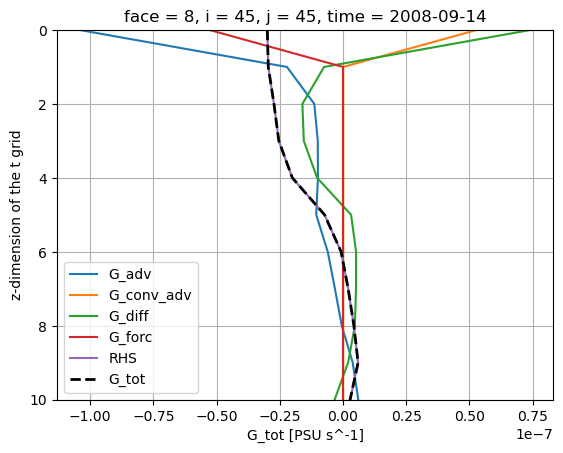

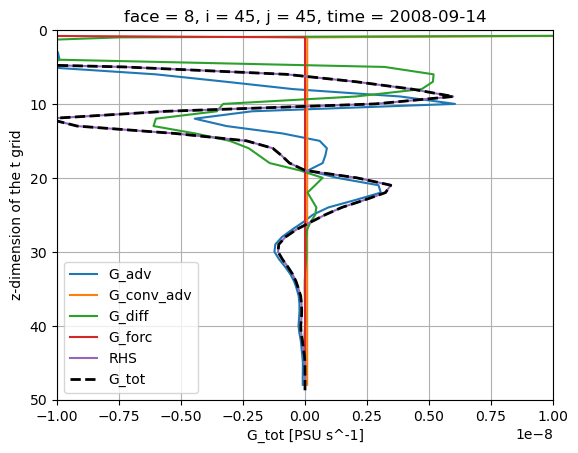

In [8]:
for xlim in [None, 1e-8]:
    plt.figure()
    ds_point.G_adv.plot(y='k', label='G_adv')
    ds_point.G_adv_conv.plot(y='k', label='G_conv_adv')
    ds_point.G_diff.plot(y='k', label='G_diff')
    ds_point.G_forc.plot(y='k', label='G_forc')
    rhs_point.plot(y='k', label='RHS')   
    ds_point.G_tot.plot(y='k', label='G_tot', color='k', ls='--', linewidth=2)   
    if xlim:
        plt.xlim([-xlim, xlim])
        plt.ylim([50, 0])
    else:
        plt.ylim([10, 0])

    plt.grid()
    plt.legend()

## Merge ryan's ds w original ecco ds to be able to use `faces_dataset_to_latlon`

In [12]:
ds_merged = xr.merge([ds, ds_original])

In [13]:
ds_merged

<xarray.Dataset>
Dimensions:     (time: 288, k: 50, face: 13, j: 90, i: 90, i_g: 90, j_g: 90,
                 k_l: 50, k_p1: 51, k_u: 50, time_snp: 287)
Coordinates: (12/37)
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i           (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g         (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...          ...
    iter        (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    iter_snp    (time_snp) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    rA          (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs         (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw         (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
Data variables: (12/41)
    G_adv       (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_adv_conv  (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_diff      (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_forc      (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_tot       (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    ADVr_SLT    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ...          ...
    basins      (face, j, i) int16 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceFWflx    (time, face, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    oceQsw      (time, face, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    oceSPtnd    (time, k, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    oceTAUX     (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceTAUY     (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>

In [14]:
ds_ll = faces_dataset_to_latlon(ds_merged)

In [16]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])

In [17]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)#(i=100, i_g=100)
ds_slt = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50, roll_coords=True)#(i=100, i_g=100)
ds_slt

<xarray.Dataset>
Dimensions:     (face: 13, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288,
                 time_snp: 287, j: 270, i: 360, j_g: 270, i_g: 360)
Coordinates:
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l         (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_p1        (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u         (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Dimensions without coordinates: j, i, j_g, i_g
Data variables: (12/41)
    G_adv       (time, k, j, i) float32 dask.array<chunksize=(48, 50, 90, 90), meta=np.ndarray>
    G_adv_conv  (time, k, j, i) float32 dask.array<chunksize=(48, 50, 90, 90), meta=np.ndarray>
    G_diff      (time, k, j, i) float32 dask.array<chunksize=(48, 50, 90, 90), meta=np.ndarray>
    G_forc      (time, k, j, i) float32 dask.array<chunksize=(48, 50, 90, 90), meta=np.ndarray>
    G_tot       (time, k, j, i) float32 dask.array<chunksize=(48, 50, 90, 90), meta=np.ndarray>
    ADVr_SLT    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ...          ...
    UVELMASS    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    VVELMASS    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    UVELSTAR    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    VVELSTAR    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    oceTAUX     (time, j, i_g) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceTAUY     (time, j_g, i) float32 dask.array<chunksize=(1, 1, 90), meta=np.ndarray>

In [18]:
ds_slt.i

<xarray.DataArray 'i' (i: 360)>
array([  0,   1,   2, ..., 357, 358, 359])
Dimensions without coordinates: i

In [19]:
ds_slt.G_adv.j

<xarray.DataArray 'j' (j: 270)>
array([  0,   1,   2, ..., 267, 268, 269])
Dimensions without coordinates: j

In [22]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 90 #-56.73891

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))
lat_range_u = dict(j_g=slice(lower_lat, upper_lat))
lon_range_u = dict(i_g=slice(left_lon, right_lon))

ds_wg = ds_slt.isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

In [24]:
volume = (coords.drF * coords.rA * coords.hFacC).isel(**lat_range, **lon_range)

In [25]:
ds_wg.ADVr_SLT.i

<xarray.DataArray 'i' (i: 95)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94])
Dimensions without coordinates: i

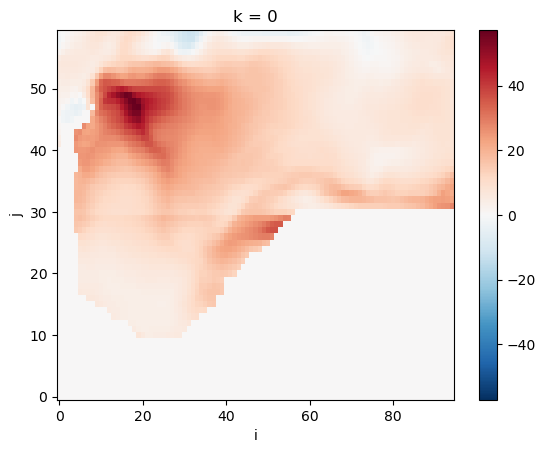

In [26]:
(ds_wg.G_tot * volume).mean(dim='time')[0].plot()

In [27]:
ds_slt_new = xr.Dataset({'G_adv':ds_wg.G_adv,
                         'G_adv_conv':ds_wg.G_adv_conv,
                         'G_diff':ds_wg.G_diff,
                         'G_forc':ds_wg.G_forc,
                         'G_tot':ds_wg.G_tot})

In [28]:
ds_slt_new = ds_slt_new * volume

## checking if new wg ds is right

In [29]:
rhs = ds_slt_new.G_adv + ds_slt_new.G_adv_conv + ds_slt_new.G_diff + ds_slt_new.G_forc

In [30]:
selector = dict(time=200, i=45, j=45)
ds_point = ds_slt_new.isel(**selector).load()
rhs_point = rhs.isel(**selector).load()

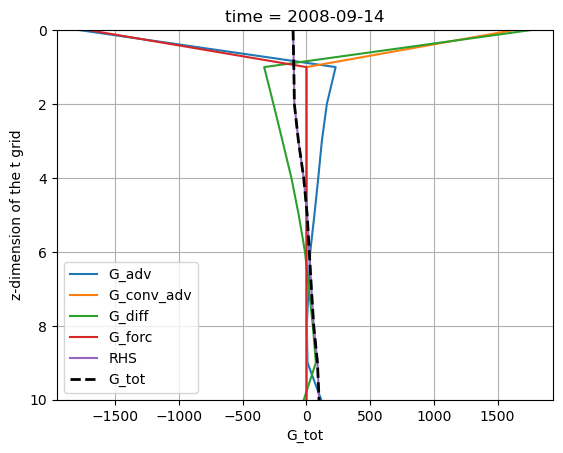

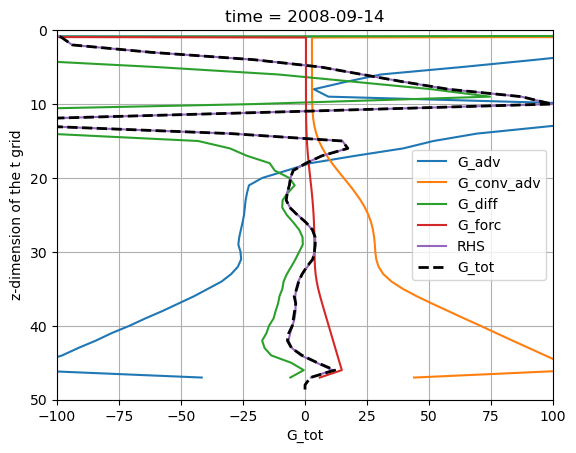

In [31]:
for xlim in [None, 1e2]:
    plt.figure()
    ds_point.G_adv.plot(y='k', label='G_adv')
    ds_point.G_adv_conv.plot(y='k', label='G_conv_adv')
    ds_point.G_diff.plot(y='k', label='G_diff')
    ds_point.G_forc.plot(y='k', label='G_forc')
    rhs_point.plot(y='k', label='RHS')   
    ds_point.G_tot.plot(y='k', label='G_tot', color='k', ls='--', linewidth=2)   
    if xlim:
        plt.xlim([-xlim, xlim])
        plt.ylim([50, 0])
    else:
        plt.ylim([10, 0])

    plt.grid()
    plt.legend()

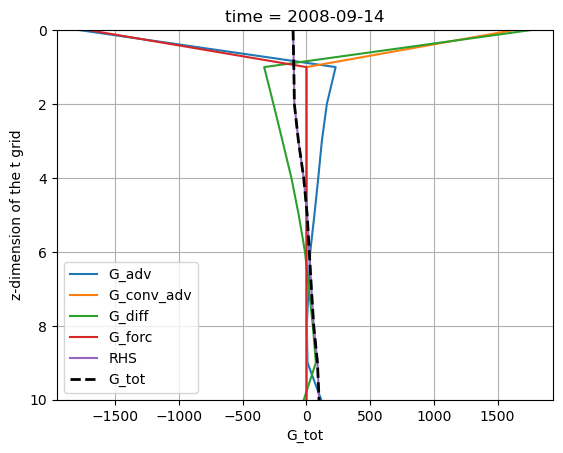

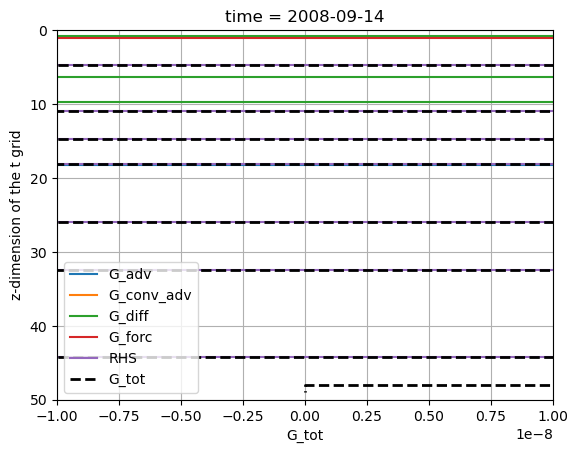

In [32]:
for xlim in [None, 1e-8]:
    plt.figure()
    ds_point.G_adv.plot(y='k', label='G_adv')
    ds_point.G_adv_conv.plot(y='k', label='G_conv_adv')
    ds_point.G_diff.plot(y='k', label='G_diff')
    ds_point.G_forc.plot(y='k', label='G_forc')
    rhs_point.plot(y='k', label='RHS')   
    ds_point.G_tot.plot(y='k', label='G_tot', color='k', ls='--', linewidth=2)   
    if xlim:
        plt.xlim([-xlim, xlim])
        plt.ylim([50, 0])
    else:
        plt.ylim([10, 0])

    plt.grid()
    plt.legend()

In [33]:
#saving ryan's salinity budget ds
gcsmap_slt_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/ECCO/ds_slt_wg_new.zarr')
ds_slt_new.to_zarr(gcsmap_slt_wg, mode='w')